<a href="https://colab.research.google.com/github/gguex/ISH_ressources_cours_ML/blob/main/tp07_arbres_forets_gb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 7 : arbres de décision, forêts aléatoires et gradient boosting

Dans ce TP, nous allons commencer par revoir les exemples simples qui ont étés montrés durant le cours. Ensuite, on va regarder quelle méthode est la plus performante entre la régression Ridge, les forêts aléatoires et le gradient boosting sur le jeu de données de régression "energy_efficiency_data.csv".

Un TP sera à faire, il s'agira de comparer des méthodes sur le jeu de données "contraceptive.tsv", afin de pouvoir prédire la méthode de contraception privilégiée de femmes selon des variables socio-économiques.

Les librairies et modules nécessaires sont :

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Pour les couleurs dans les graphes
from matplotlib.colors import ListedColormap
# On redimmensionne la fenêtre de sortie graphique
plt.rcParams['figure.figsize'] = [12, 12]
# Module contenant les classes et méthodes pour les arbres de décision
from sklearn import tree
# Les méthodes ensemblistes
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, \
  GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
# Cette librairie nous permet d'afficher et de sauver les arbres de décisions
import graphviz

## 1. Jeu de données du Titanic

Pour commencer, nous allons faire des arbres simples à partir du jeu de données d'entrainement du Titanic ("train.csv" - https://www.kaggle.com/c/titanic/data?select=train.csv).

On charge le jeu de données, et on enlève les individus dont les données manquent sur les variables que nous allons utiliser.

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP7/train.csv"
data = pd.read_csv(file_path)
data = data.dropna(subset=["Survived", "Sex", "Age"])
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Les entrées de nos arbres seront uniquement constituées de l'age et du genre. On doit recoder notre variable de genre en binaire.

In [ ]:
onehot_Sex = pd.get_dummies(data["Sex"], drop_first=True)
inputs = pd.concat([data["Age"], onehot_Sex], axis=1)
outputs = data["Survived"]

Le module `tree` de `sklearn` contient plusieurs classes et méthodes relatives aux arbres, dont la classe `DecisionTreeClassifier` qui permet de faire des arbres de classification. On entraine notre modèle.

In [ ]:
classif_tree = tree.DecisionTreeClassifier()
classif_tree.fit(inputs, outputs)

DecisionTreeClassifier()

Grâce à la libraire `graphviz`, on peut afficher au sauvegarder nos arbres de décisions (pour sauver, décommentez la dernière ligne). On remarque notre arbre est giganteste, et sûrement beaucoup trop sur-paramétrisé.

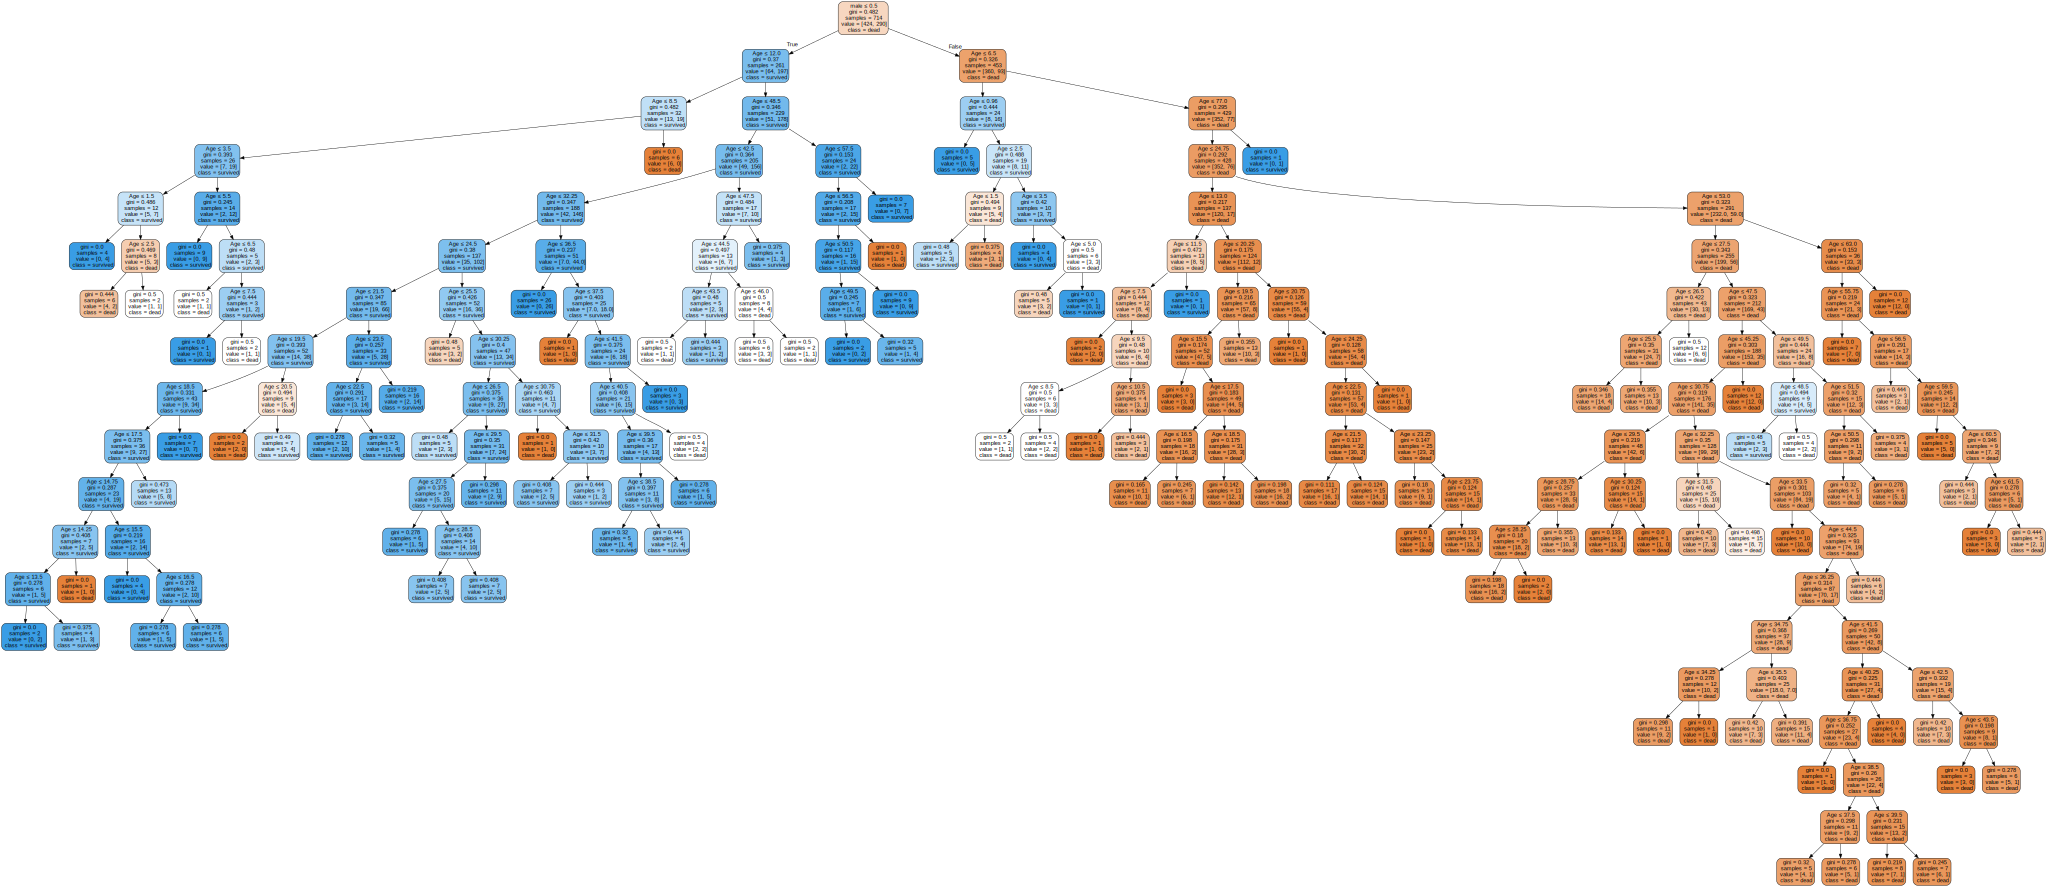

In [ ]:
gvz_data = tree.export_graphviz(classif_tree, out_file=None,
                                feature_names=inputs.columns,
                                class_names=["dead", "survived"],
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(gvz_data)
graph
# Pour sauver l'arbre (txt + pdf), decommentez ci-dessous
# graph.render("titanic")

On va refaire un arbre, mais cette fois-ci en l'élaguant. On pose pour cela une valeur `ccp_alpha`, ce qui va augmenter le coût des arbres avec de nombreuses feuilles et privilégier les petits arbres. Les résultats sont nettement plus interprétables.

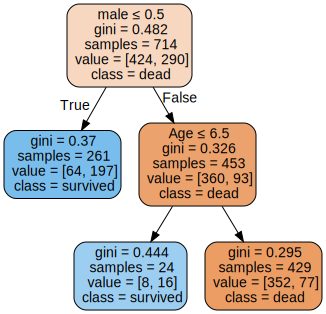

In [ ]:
classif_tree_pruned = tree.DecisionTreeClassifier(ccp_alpha=0.005)
classif_tree_pruned.fit(inputs, outputs)
gvz_data = tree.export_graphviz(classif_tree_pruned, out_file=None,
                                feature_names=inputs.columns,
                                class_names=["dead", "survived"],
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(gvz_data)
graph


---


## 2. Les iris

On va maintenant faire des arbres et forêts sur les iris de Fisher (et oui, encore). Cela nous permettra de tracer les frontière de décisions.

On charge le jeu de données.

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP7/iris.csv"
data = pd.read_csv(file_path)

En faisant un arbre élagué sur la taille des sépales, on obtient le résultat suivant.

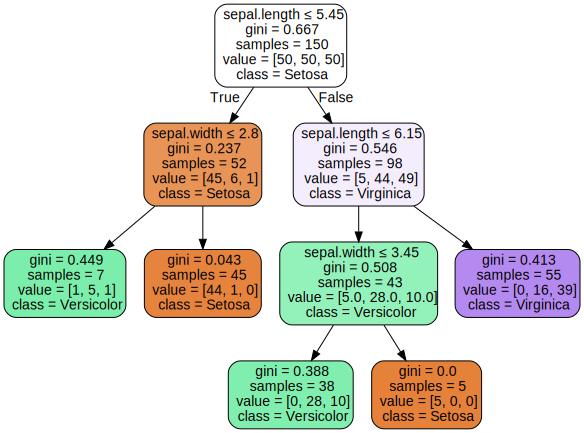

In [ ]:
classif_tree = tree.DecisionTreeClassifier(ccp_alpha=0.02)
classif_tree.fit(data[["sepal.length", "sepal.width"]], data["variety"])
gvz_data = tree.export_graphviz(classif_tree, out_file=None,
                                feature_names=["sepal.length", "sepal.width"],
                                class_names=classif_tree.classes_,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(gvz_data)
graph

Ce qui correspond aux frontières de décision suivantes. (en utilisant une fois encore `meshgrid`, et en prédisant l'appartenance de toutes les cases de notre mesh)

<ipython-input-9-5334b26ecd7d>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grid_pred_num = pd.Series(grid_pred).replace(


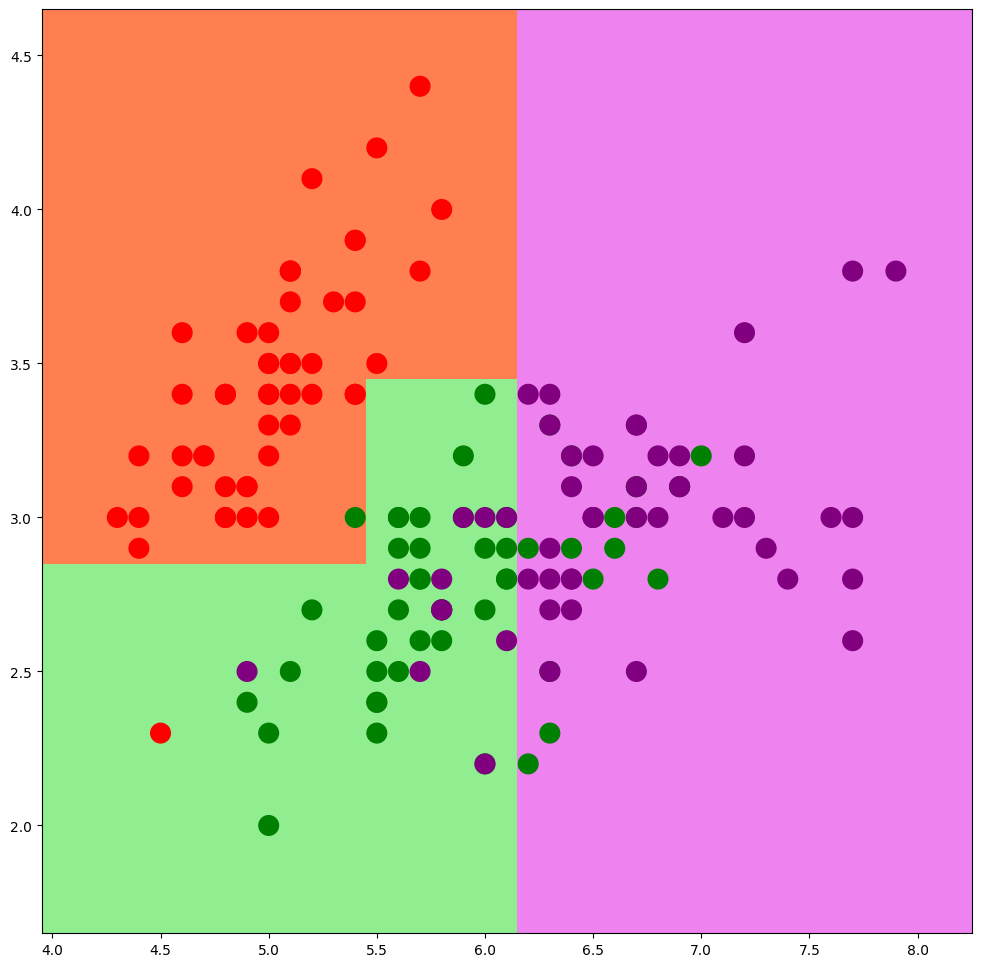

In [ ]:
# La taille de la mesh
mesh_size = 0.1
# On fixe les limites
x_min = data["sepal.length"].min() - 3*mesh_size
x_max = data["sepal.length"].max() + 3*mesh_size
y_min = data["sepal.width"].min() - 3*mesh_size
y_max = data["sepal.width"].max() + 3*mesh_size
# On définit notre mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                      np.arange(y_min, y_max, mesh_size))
# On fait les prédictions, que l'on transforme en valeurs numériques
grid_inputs = pd.DataFrame({"sepal.length": xx.ravel(),
                            "sepal.width": yy.ravel()})
grid_pred = classif_tree.predict(grid_inputs)
# Couleurs
color_dict = {"Virginica": "purple", "Versicolor": "green", "Setosa": "red"}
mesh_cmap = ListedColormap(["violet", "lightgreen", "coral"])
# Vecteurs de couleur & niveau
color_vec = [color_dict[label] for label in data["variety"]]
grid_pred_num = pd.Series(grid_pred).replace(
    ["Virginica", "Versicolor", "Setosa"], [0, 1, 2])
grid_pred_num = grid_pred_num.to_numpy().reshape(xx.shape)
# On créée le graphique
fig, ax = plt.subplots()
ax.pcolormesh(xx, yy, grid_pred_num, cmap=mesh_cmap)
ax.scatter(data["sepal.length"], data["sepal.width"], c=color_vec, s=200)
# Pour sauver en pdf, decommentez ci-dessous
#plt.savefig("iris.png")
plt.show()

Comparons les résultats obtenus avec une forêt. On va en faire une relativement petite (9 arbres) avec une profondeur de 2. Comme on a que deux variables, on va a chaque fois en sélectionner une des deux pour construire notre arbre.

In [ ]:
classif_forest = RandomForestClassifier(n_estimators=9, max_depth=2,
                                        max_features=1)
classif_forest.fit(data[["sepal.length", "sepal.width"]], data["variety"])

RandomForestClassifier(max_depth=2, max_features=1, n_estimators=9)

Les arbres de notre forêt sont stockés dans l'attribut `estimators_`. On peut alors en sortir un en particulier et l'afficher.

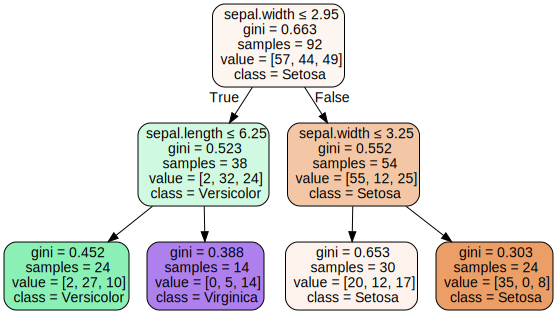

In [ ]:
# Pour voir un des arbres
estimator_tree = classif_forest.estimators_[0]
gvz_data = tree.export_graphviz(estimator_tree, out_file=None,
                                feature_names=["sepal.length", "sepal.width"],
                                class_names=classif_tree.classes_,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(gvz_data)
graph

Regardons maintenant les frontières de décision. On voit qu'elles sont beaucoup plus adaptées aux données (mais possiblement sur-entrainées).

<ipython-input-12-814aa8310ff7>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grid_pred_num = pd.Series(grid_pred).replace(


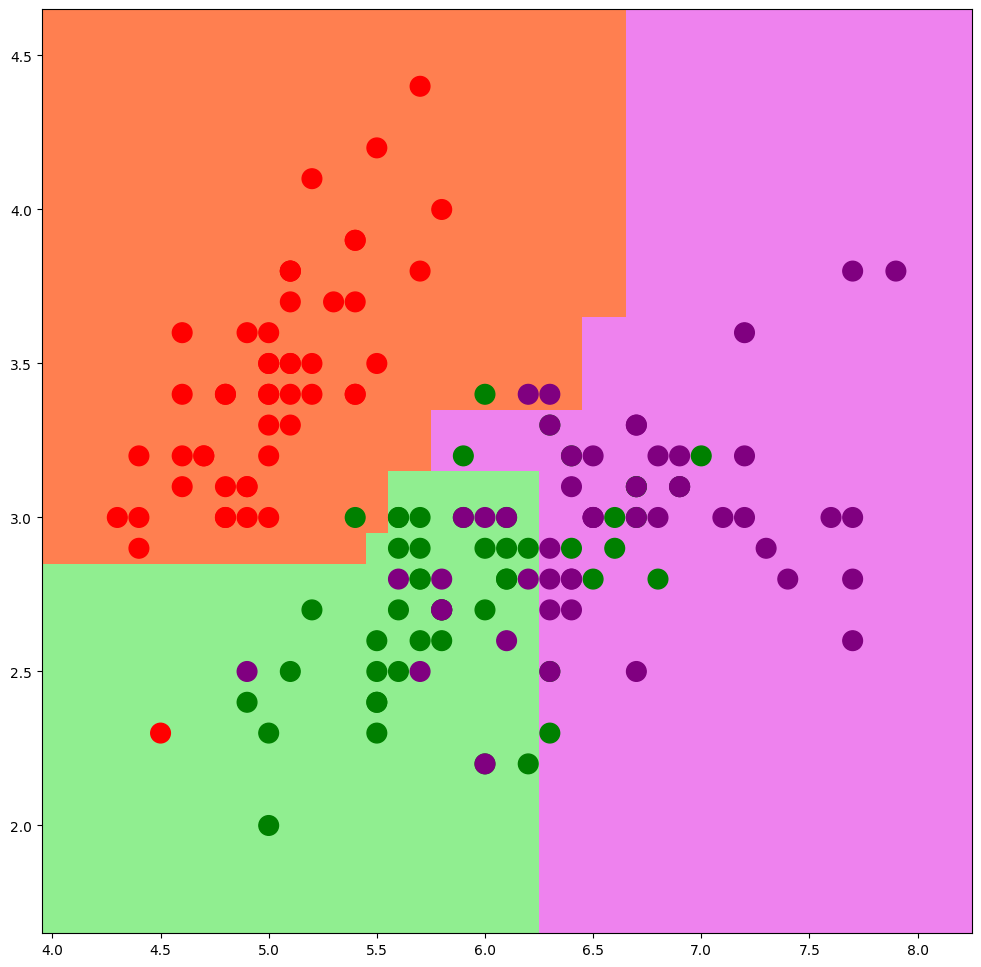

In [ ]:
# La taille de la mesh
mesh_size = 0.1
# On fixe les limites
x_min = data["sepal.length"].min() - 3*mesh_size
x_max = data["sepal.length"].max() + 3*mesh_size
y_min = data["sepal.width"].min() - 3*mesh_size
y_max = data["sepal.width"].max() + 3*mesh_size
# On définit notre mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                      np.arange(y_min, y_max, mesh_size))
# On fait les prédictions, que l'on transforme en valeurs numériques
grid_inputs = pd.DataFrame({"sepal.length": xx.ravel(),
                            "sepal.width": yy.ravel()})
grid_pred = classif_forest.predict(grid_inputs)
# Couleurs
color_dict = {"Virginica": "purple", "Versicolor": "green", "Setosa": "red"}
mesh_cmap = ListedColormap(["violet", "lightgreen", "coral"])
# Vecteurs de couleur & niveau
color_vec = [color_dict[label] for label in data["variety"]]
grid_pred_num = pd.Series(grid_pred).replace(
    ["Virginica", "Versicolor", "Setosa"], [0, 1, 2])
grid_pred_num = grid_pred_num.to_numpy().reshape(xx.shape)
# On créée le graphique
fig, ax = plt.subplots()
ax.pcolormesh(xx, yy, grid_pred_num, cmap=mesh_cmap)
ax.scatter(data["sepal.length"], data["sepal.width"], c=color_vec, s=200)
# Pour sauver en pdf, decommentez ci-dessous
#plt.savefig("iris_forest.png")
plt.show()



---


# 3. Utilisation dans une tâche de régression

Ici, nous allons utiliser le jeu de données "energy_efficiency_data.csv" (https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set) qui contient des variables sur des maisons, ainsi que leurs besoins énergétiques pour les réchauffer ou les refroidire. Nous allons essayer de prédire ces besoins, et de voir quelles variables sont pertinentes. On va utiliser 3 modèles :

- La régression Ridge
- Les forêts aléatoires pour la régression.
- Le gradient boosting pour la régression.

On commence par charger les données.

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP7/energy_efficiency_data.csv"
data = pd.read_csv(file_path)
data

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


La variable *Glazing_Area_Distribution* n'est pas utile dans la prédiction, on la laisse donc tomber. On doit aussi convertir la variable catégorielle *Orientation* en variables one-hot.

In [ ]:
pre_inputs = data.drop(["Glazing_Area_Distribution", "Heating_Load",
                        "Cooling_Load"], axis=1)
orientation_dummies = pd.get_dummies(pre_inputs["Orientation"], prefix="or")
inputs = pd.concat([pre_inputs.drop("Orientation", axis=1),
                    orientation_dummies], axis=1)

Il y aura deux sorties possibles (2 régressions), l'energie pour chauffer et l'energie pour refroidir.

In [ ]:
h_outputs = data["Heating_Load"]
c_outputs = data["Cooling_Load"]

Commençons par faire deux arbres de décisions simples, qui nous permettrons d'avoir un avis rapide sur les données. La surface du toit semble jouer un grand rôle dans le réchauffement de la maison, et la "compactness" est utile au réchauffement. Les scores de ces régressions sont également donnés (il s'agit ici du $R^2$, et non pas de la MSE).

In [ ]:
h_reg_tree = tree.DecisionTreeRegressor(ccp_alpha=2).fit(inputs, h_outputs)
c_reg_tree = tree.DecisionTreeRegressor(ccp_alpha=1).fit(inputs, c_outputs)
print(f"Score heating: {h_reg_tree.score(inputs, h_outputs)}")
print(f"Score cooling: {c_reg_tree.score(inputs, h_outputs)}")

Score heating: 0.9044831761353854
Score cooling: 0.84865137474036


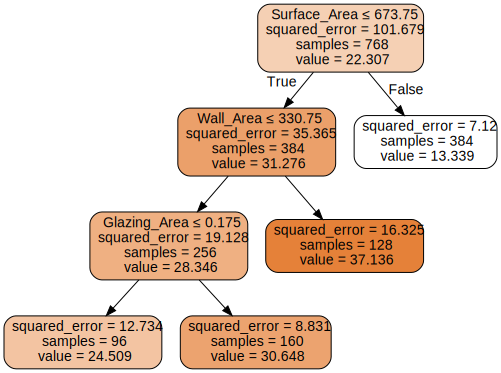

In [ ]:
gvz_data = tree.export_graphviz(h_reg_tree, out_file=None,
                                feature_names=inputs.columns,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(gvz_data)
graph

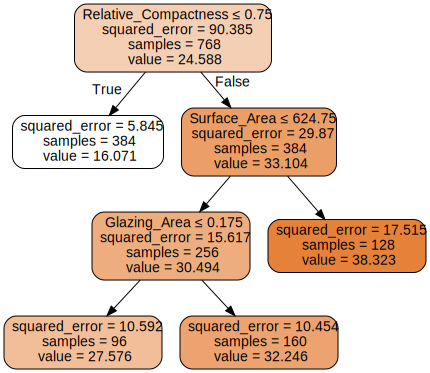

In [ ]:
gvz_data = tree.export_graphviz(c_reg_tree, out_file=None,
                                feature_names=inputs.columns,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(gvz_data)
graph

On va maintenant séparer nos données en jeux d'entrainement/validation et test.

In [ ]:
inputs_tv, inputs_test, h_outputs_tv, h_outputs_test, c_outputs_tv, \
c_outputs_test = train_test_split(inputs, h_outputs, c_outputs)

On effectue une recherche sur grille avec CV pour la régression Ridge, en faisant varier le paramètre de régularisation (pour chacune des variables de sortie).

In [ ]:
reg_hyperp = {"alpha": np.linspace(0.0001, 0.1, 100)}
h_reg_grid = GridSearchCV(Ridge(), reg_hyperp).fit(inputs_tv, h_outputs_tv)
c_reg_grid = GridSearchCV(Ridge(), reg_hyperp).fit(inputs_tv, c_outputs_tv)

Le modèle est déjà meilleur que nos arbres, surtout que, contrairement aux arbres, le résultat a été obtenu sur un jeu de test.

In [ ]:
print(f"Reg best param for heating: {h_reg_grid.best_params_}")
print(f"Score: {h_reg_grid.best_estimator_.score(inputs_test, h_outputs_test)}")
print(f"Reg best param for cooling: {c_reg_grid.best_params_}")
print(f"Score: {c_reg_grid.best_estimator_.score(inputs_test, c_outputs_test)}")

Reg best param for heating: {'alpha': 0.002118181818181818}
Score: 0.9148003775876166
Reg best param for cooling: {'alpha': 0.002118181818181818}
Score: 0.8819082847322945


On fait maintenant une autre recherche sur grille et CV pour la forêt aléatoire, en faisant varier la profondeur maximale des arbres.

In [ ]:
forest_hyperp = {"max_depth": range(1, 11)}
h_forest_grid = GridSearchCV(RandomForestRegressor(),
                             forest_hyperp).fit(inputs_tv, h_outputs_tv)
c_forest_grid = GridSearchCV(RandomForestRegressor(),
                             forest_hyperp).fit(inputs_tv, c_outputs_tv)

Le résultat s'améliore nettement.

In [ ]:
print(f"Forest best param for heating: {h_forest_grid.best_params_}")
print(f"Score: {h_forest_grid.best_estimator_.score(inputs_test, h_outputs_test)}")
print(f"Forest best param for cooling: {c_forest_grid.best_params_}")
print(f"Score: {c_forest_grid.best_estimator_.score(inputs_test, c_outputs_test)}")

Forest best param for heating: {'max_depth': 7}
Score: 0.9965274021234338
Forest best param for cooling: {'max_depth': 6}
Score: 0.9591898811677292


Finalement, on effectue notre gradient boosting, en faisant varier la profondeur maximale des arbres et le taux d'apprentissage.

In [ ]:
grad_hyperp = {"max_depth": range(1, 7), "learning_rate": np.linspace(0.01, 0.2, 10)}
h_grad_grid = GridSearchCV(GradientBoostingRegressor(),
                           grad_hyperp).fit(inputs_tv, h_outputs_tv)
c_grad_grid = GridSearchCV(GradientBoostingRegressor(),
                           grad_hyperp).fit(inputs_tv, c_outputs_tv)

Le résultat est sensiblement meilleur.

In [ ]:
print(f"GB best param for heating: {h_grad_grid.best_params_}")
print(f"Score: {h_grad_grid.best_estimator_.score(inputs_test, h_outputs_test)}")
print(f"GB best param for cooling: {c_grad_grid.best_params_}")
print(f"Score: {c_grad_grid.best_estimator_.score(inputs_test, c_outputs_test)}")

GB best param for heating: {'learning_rate': 0.11555555555555555, 'max_depth': 3}
Score: 0.9974142893610903
GB best param for cooling: {'learning_rate': 0.2, 'max_depth': 2}
Score: 0.9681230390166213


Afin de pouvoir identifier les variables pertientes qui ont servi dans nos modèles, on peut se servir de plusieurs éléments. Pour la régression Ridge, on peut regarder les coéfficients de régression, qui ont l'avantage de nous donner aussi le sens de la corrélation. Pour les méthodes d'ensemble, l'argument `feature_importances_` permet d'obtenir l'importances des différentes variables dans la modèle, mais sans donner le sens de l'effet. On voit que les variables importantes ne sont pas entièrement les mêmes pour les trois modèles, mais certaines ressortent régulièrement ("compactness", "height").

[]

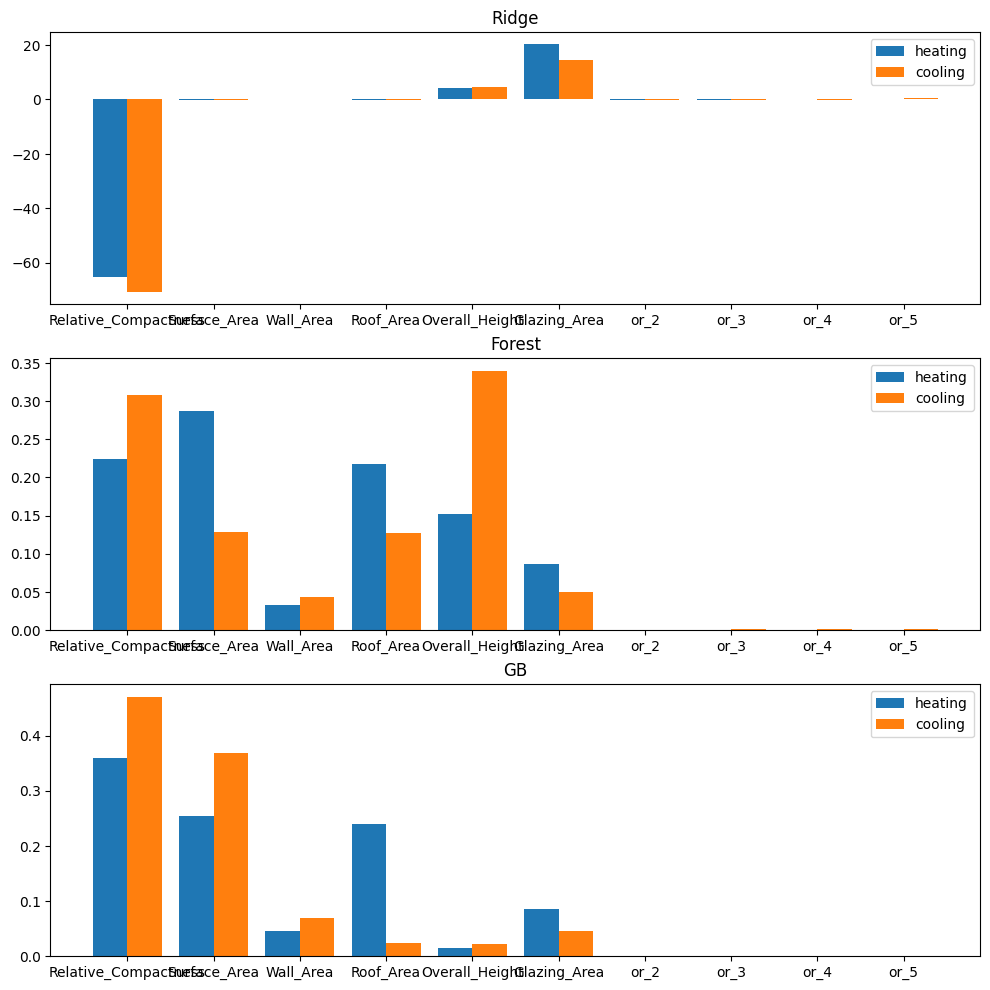

In [ ]:
# Création des objets servant à l'affichage graphique
fig, axs = plt.subplots(3, 1)
# Pour faire une double bar
x_axis = np.arange(len(inputs.columns))
plt.setp(axs, xticks=x_axis, xticklabels=inputs.columns)
# Ridge regression
axs[0].bar(x_axis - 0.2, h_reg_grid.best_estimator_.coef_,
           0.4, label = "heating")
axs[0].bar(x_axis + 0.2, c_reg_grid.best_estimator_.coef_,
           0.4, label = "cooling")
axs[0].set_title("Ridge")
axs[0].legend(loc="upper right")
# Forest regression
axs[1].bar(x_axis - 0.2, h_forest_grid.best_estimator_.feature_importances_,
           0.4, label = "heating")
axs[1].bar(x_axis + 0.2, c_forest_grid.best_estimator_.feature_importances_,
           0.4, label = "cooling")
axs[1].set_title("Forest")
axs[1].legend(loc="upper right")
# Gradient boosting
axs[2].bar(x_axis - 0.2, h_grad_grid.best_estimator_.feature_importances_,
           0.4, label = "heating")
axs[2].bar(x_axis + 0.2, c_grad_grid.best_estimator_.feature_importances_,
           0.4, label = "cooling")
axs[2].set_title("GB")
axs[2].legend(loc="upper right")
plt.plot()

## 4. TP

Dans ce TP, vous allez utiliser le jeu de données "contraceptive.tsv" (https://www.kaggle.com/datasets/faizunnabi/contraceptive-method-choice) qui donne des variables socio-économiques pour plusieurs femmes, ainsi que leur méthode de contraceptition privilégiée (dans la variable target, avec 1=aucune, 2=méthode long-terme, 3=méthode court-terme). Le but est d'utiliser ces variables pour prédire la méthode de contraception (c'est une classification). Plus spécifiquement il vous faut :

- Faire un arbre de classification (de taille raisonnable) sur toutes les données.
- Faire un régression logistique régularisée, ou le paramètre `C` devra être optimisé via `GridSearchCV`.
- Faire une forêt aléatoire, ou le paramètre `max_depth` devra être optimisé via `GridSearchCV`.
- Faire un gradient boosting, ou le paramètre `max_depth` devra être optimisé via `GridSearchCV`.
- Comparer les trois méthodes sur un jeu de test.
- Afficher l'importance des différentes variables pour la forêt aléatoire et le gradient boosting.

Bonne chance !